In [2]:
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install tensorflow

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


C:\Users\Ash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\Ash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\Ash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313

In [8]:
ticker = ("NVDA")
years_of_data = 5
prediction_days = 60
future_days = 252


C:\Users\Ash\AppData\Local\Temp\ipykernel_25012\3731700603.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


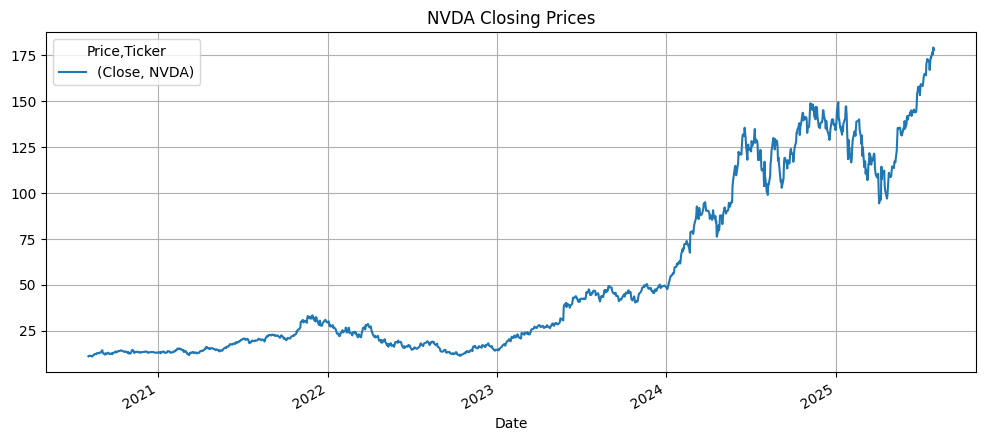

In [9]:
# Get data for the past 5 years
end = pd.Timestamp.today()
start = end - pd.DateOffset(years=years_of_data)
df = yf.download(ticker, start=start, end=end)
data = df[['Close']].dropna()

# Visualize historical closing price
data.plot(figsize=(12, 5), title=f"{ticker} Closing Prices")
plt.grid()
plt.show()


In [10]:
# Normalize closing prices to 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create X (inputs) and y (targets) for model
X, y = [], []
for i in range(prediction_days, len(scaled_data) - future_days):
    X.append(scaled_data[i - prediction_days:i, 0])
    y.append(scaled_data[i:i + future_days, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=future_days))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, y, epochs=20, batch_size=32)


Epoch 1/20


C:\Users\Ash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0667
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0160
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0127
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0117
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0112
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0097
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0096
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0091
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0092
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0084
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0082
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0079
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0077
Epoch 16/20
30/

In [12]:
last_sequence = scaled_data[-prediction_days:]
last_sequence = np.reshape(last_sequence, (1, prediction_days, 1))
predicted_scaled = model.predict(last_sequence)
predicted_prices = scaler.inverse_transform(predicted_scaled).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


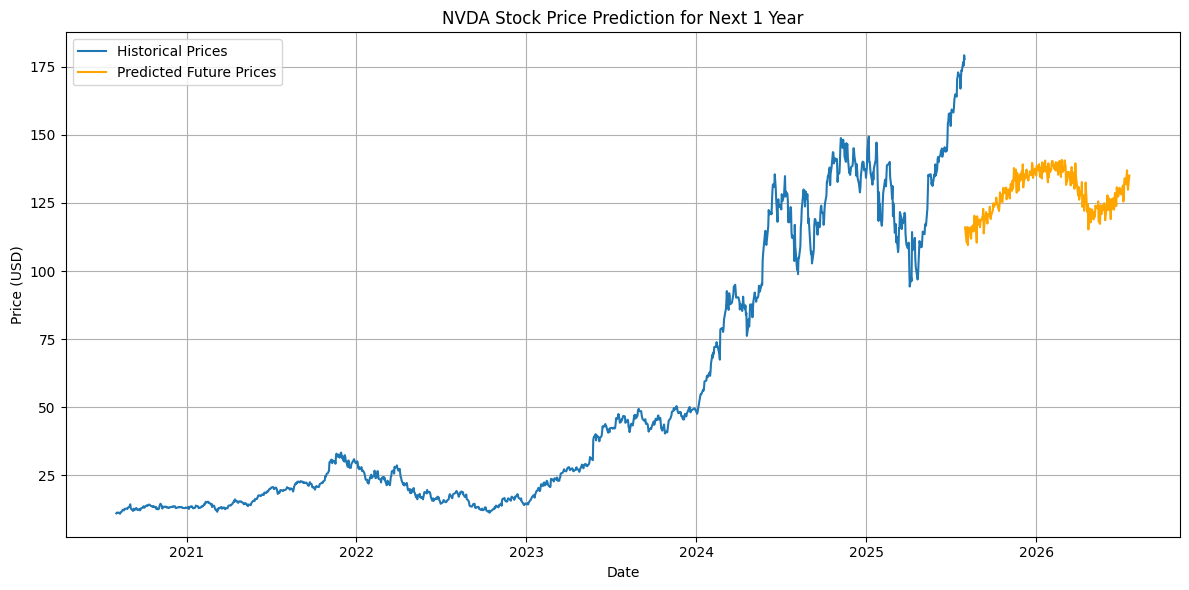

In [13]:
last_known_date = data.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), periods=future_days, freq='B')

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label="Historical Prices")
plt.plot(future_dates, predicted_prices, color='orange', label="Predicted Future Prices")
plt.title(f"{ticker} Stock Price Prediction for Next 1 Year")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
